# Codon Usage Data Ensemble Learning

This assignment discusses classifying the kingdom of a species based on DNA codon data using different ensemble classification methods, specifically XGBoost and stacking. In the Codon dataset, there are several attributes such as Kingdom, DNAtype, SpeciesID, Ncodons, SpeciesName, and Codon. The Codon dataset is used to build a classification model to determine the Kingdom class of a specific Codon.

# Load libraries and data

First, the required libraries will be imported for the classification process.

In [ ]:
# import necessary libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing

# evaluate xgboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
#from sklearn.ensemble import StackingClassifier
from matplotlib import pyplot

In [ ]:
#data=pd.read_csv('Downloads/codon_usage.csv')

In [ ]:
data = pd.read_csv('codon_usage.csv')

# Exploratory Data Analysis (EDA)

The dataset consists of 69 columns, where 64 columns show the frequency of each codon such as ‘UUU’, ‘UUA’, and so on. The other columns are speciesid, speciesname, ncodons, dnatype, and kingdom.

In [ ]:
data.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


It can be seen that the data type for Codon is float64, consistent with the dataset description using decimal numbers. Meanwhile, other columns such as DNAtype, speciesID, and Ncodons are int64. The kingdom and SpeciesName columns are objects

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  object 
 1   DNAtype      13028 non-null  int64  
 2   SpeciesID    13028 non-null  int64  
 3   Ncodons      13028 non-null  int64  
 4   SpeciesName  13028 non-null  object 
 5   UUU          13028 non-null  float64
 6   UUC          13028 non-null  float64
 7   UUA          13028 non-null  float64
 8   UUG          13028 non-null  float64
 9   CUU          13028 non-null  float64
 10  CUC          13028 non-null  float64
 11  CUA          13028 non-null  float64
 12  CUG          13028 non-null  float64
 13  AUU          13028 non-null  float64
 14  AUC          13028 non-null  float64
 15  AUA          13028 non-null  float64
 16  AUG          13028 non-null  float64
 17  GUU          13028 non-null  float64
 18  GUC          13028 non-null  float64
 19  GUA 

Change the DNAType and SpeciesID columns to object

In [ ]:
data['DNAtype']=data['DNAtype'].astype('O')
data['SpeciesID']=data['SpeciesID'].astype('O')

In [ ]:
data.describe(include='O')

,Kingdom,DNAtype,SpeciesID,SpeciesName
count,13028,13028,13028,13028
unique,11,11,12368,13016
top,bct,0,3885,Escherichia coli O157
freq,2920,9267,4,4


In [ ]:
dataob=data[['Kingdom','DNAtype']].reset_index()

In [ ]:
aggkingdom = dataob.groupby(['Kingdom'])[['index']].count().reset_index()

In the dataset, there are 11 kingdom labels to be classified, and the distribution of each label can be seen in the plot image below. The proportion of each label is imbalanced, so it can be considered imbalanced data. There are labels with very large counts (majority) and some with very small counts (minority).

<BarContainer object of 11 artists>

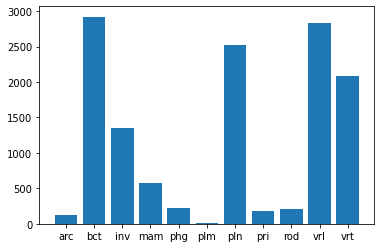

In [ ]:
plt.bar(aggkingdom['Kingdom'],aggkingdom['index'])

# Pre-processing

## Duplicate data

Check for duplicate data by calling the function below. It can be seen that because no rows appear in the dataframe, it indicates there is no duplicate data in the dataset

In [ ]:
data[data.duplicated()]

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA


## Missing data

There is some missing data in the uuu and uuc columns, identified from their data type being object, which should be float like the other codon columns, and an error appears when attempting to convert them to float, then drop na is performed to remove null data

In [ ]:
data['UUU']=data['UUU'].astype('float64')
data['UUC']=data['UUC'].astype('float64')

In [ ]:
data = data.dropna()

In [ ]:

label_encoder = preprocessing.LabelEncoder()
data['Kingdom']= label_encoder.fit_transform(data['Kingdom'])


In [ ]:
data.head()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,9,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,9,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,9,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.02180,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,9,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,9,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [ ]:
label_encoder.classes_

array(['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
       'vrl', 'vrt'], dtype=object)

## Normalisasi min max

Min–max normalization is applied to the codon feature data to standardize the scale of numeric values across each Codon feature

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13028 entries, 0 to 13027
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Kingdom      13028 non-null  int64  
 1   DNAtype      13028 non-null  object 
 2   SpeciesID    13028 non-null  object 
 3   Ncodons      13028 non-null  int64  
 4   SpeciesName  13028 non-null  object 
 5   UUU          13028 non-null  float64
 6   UUC          13028 non-null  float64
 7   UUA          13028 non-null  float64
 8   UUG          13028 non-null  float64
 9   CUU          13028 non-null  float64
 10  CUC          13028 non-null  float64
 11  CUA          13028 non-null  float64
 12  CUG          13028 non-null  float64
 13  AUU          13028 non-null  float64
 14  AUC          13028 non-null  float64
 15  AUA          13028 non-null  float64
 16  AUG          13028 non-null  float64
 17  GUU          13028 non-null  float64
 18  GUC          13028 non-null  float64
 19  GUA 

In [ ]:
X=data.drop(['Kingdom', 'DNAtype', 'SpeciesID','Ncodons','SpeciesName'],axis=1)
y=data['Kingdom']

In [ ]:
X=(X-X.min())/(X.max()-X.min())

After scaling, it can be seen that all codon features become float64

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13028 entries, 0 to 13027
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   UUU     13028 non-null  float64
 1   UUC     13028 non-null  float64
 2   UUA     13028 non-null  float64
 3   UUG     13028 non-null  float64
 4   CUU     13028 non-null  float64
 5   CUC     13028 non-null  float64
 6   CUA     13028 non-null  float64
 7   CUG     13028 non-null  float64
 8   AUU     13028 non-null  float64
 9   AUC     13028 non-null  float64
 10  AUA     13028 non-null  float64
 11  AUG     13028 non-null  float64
 12  GUU     13028 non-null  float64
 13  GUC     13028 non-null  float64
 14  GUA     13028 non-null  float64
 15  GUG     13028 non-null  float64
 16  GCU     13028 non-null  float64
 17  GCC     13028 non-null  float64
 18  GCA     13028 non-null  float64
 19  GCG     13028 non-null  float64
 20  CCU     13028 non-null  float64
 21  CCC     13028 non-null  float64
 22

In [ ]:
print(X)

            UUU       UUC       UUA       UUG       CUU       CUC       CUA  \
0      0.076116  0.131203  0.003304  0.034687  0.133994  0.319681  0.006101   
1      0.124896  0.147999  0.004493  0.067003  0.045333  0.283906  0.012445   
2      0.090842  0.237758  0.089672  0.152485  0.087102  0.110713  0.062714   
3      0.081684  0.244847  0.106985  0.098033  0.174538  0.135326  0.057345   
4      0.129590  0.149526  0.050684  0.363573  0.153709  0.054609  0.028856   
...         ...       ...       ...       ...       ...       ...       ...   
13023  0.117441  0.387719  0.036146  0.135092  0.142125  0.208969  0.050024   
13024  0.057892  0.348239  0.131104  0.062160  0.161617  0.530344  0.466325   
13025  0.065486  0.362199  0.109760  0.035181  0.125529  0.502441  0.586201   
13026  0.080856  0.221180  0.050684  0.127779  0.146915  0.195217  0.043619   
13027  0.081822  0.406151  0.114452  0.059294  0.188127  0.384056  0.427038   

            CUG       AUU       AUC  ...       CGG 

# Modelling

## XGBoost

The XGBoost classifier model is tested using stratified fold cross-validation. Hyperparameters are tested by varying the number of n_estimator values to 10, 50, 100, 600 with the same learning rate of 0.02

In [ ]:
# example of grid searching key hyperparameters for adaboost on a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
#from sklearn.ensemble import XGBClassifier
from xgboost import XGBClassifier

# define dataset


# define the model with default hyperparameters
model10 = XGBClassifier()

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 600]
grid['learning_rate'] = [0.001, 0.01, 0.1, 0.02, 0.2]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model10, param_grid=grid, n_jobs=-1, cv=cv,
scoring='accuracy')

# execute the grid search
grid_result = grid_search.fit(X, y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:

# define the model
model = XGBClassifier(learning_rate=0.02, n_estimators=20,num_class=11, objective='multi:softmax',
                    silent=True, nthread=1)
print(model)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model on the dataset
n_scores20 = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores20), std(n_scores20)))

XGBClassifier(learning_rate=0.02, n_estimators=20, nthread=1, num_class=11,
              objective='multi:softmax', silent=True)
Mean Accuracy: 0.715 (0.008)


In [ ]:
n_scores20

array([0.70069071, 0.70836531, 0.72601688, 0.71450499, 0.72601688,
       0.69992325, 0.70606293, 0.71987721, 0.72887865, 0.72427035,
       0.70529547, 0.70759785, 0.71066769, 0.70913277, 0.71373753,
       0.72294705, 0.72141213, 0.71910975, 0.70814132, 0.7281106 ,
       0.70990023, 0.71373753, 0.71987721, 0.72064467, 0.72524942,
       0.69992325, 0.71373753, 0.71603991, 0.70583717, 0.71121352])

In [ ]:

# define the model
model = XGBClassifier(learning_rate=0.02, n_estimators=50,num_class=11, objective='multi:softmax',
                    silent=True, nthread=1)
print(model)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model on the dataset
n_scores50 = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores50), std(n_scores50)))

XGBClassifier(learning_rate=0.02, n_estimators=50, nthread=1, num_class=11,
              objective='multi:softmax', silent=True)
Mean Accuracy: 0.739 (0.009)


In [ ]:
n_scores50

array([0.71680737, 0.73292402, 0.74750576, 0.742901  , 0.74750576,
       0.73292402, 0.74366846, 0.73983116, 0.75038402, 0.75729647,
       0.73676132, 0.72678434, 0.73599386, 0.73215656, 0.73445894,
       0.74597084, 0.74904068, 0.74520338, 0.7311828 , 0.75115207,
       0.73445894, 0.73829624, 0.73983116, 0.75057559, 0.75441289,
       0.72831926, 0.73369148, 0.72678434, 0.73809524, 0.73348694])

In [ ]:

# define the model
model = XGBClassifier(learning_rate=0.02, n_estimators=100,num_class=11, objective='multi:softmax',
                    silent=True, nthread=1)
print(model)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model on the dataset
n_scores100 = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores100), std(n_scores100)))

XGBClassifier(learning_rate=0.02, nthread=1, num_class=11,
              objective='multi:softmax', silent=True)
Mean Accuracy: 0.772 (0.008)


In [ ]:
n_scores100

array([0.75287797, 0.76745971, 0.77743668, 0.76745971, 0.78587874,
       0.77052955, 0.77129701, 0.76669225, 0.78033794, 0.77726575,
       0.76745971, 0.77052955, 0.75594781, 0.76285495, 0.76976209,
       0.77973906, 0.78204144, 0.77743668, 0.7749616 , 0.77726575,
       0.76822717, 0.77820414, 0.77129701, 0.78511128, 0.78357636,
       0.76438987, 0.77283193, 0.76285495, 0.7688172 , 0.76651306])

In [ ]:
# define the model
model = XGBClassifier(learning_rate=0.02, n_estimators=600,num_class=11, objective='multi:softmax',
                    silent=True, nthread=1)
print(model)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model on the dataset
n_scores600 = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores600), std(n_scores600)))

XGBClassifier(learning_rate=0.02, n_estimators=600, nthread=1, num_class=11,
              objective='multi:softmax', silent=True)
Mean Accuracy: 0.886 (0.009)


In [ ]:
n_scores600

array([0.88718342, 0.87260169, 0.87643899, 0.89639294, 0.89409056,
       0.88871834, 0.88257866, 0.8818112 , 0.89477727, 0.88095238,
       0.88257866, 0.88334612, 0.86569455, 0.87797391, 0.8818112 ,
       0.89102072, 0.89102072, 0.90023024, 0.88940092, 0.88709677,
       0.88334612, 0.88795088, 0.88104375, 0.91250959, 0.89639294,
       0.87643899, 0.89409056, 0.88257866, 0.87403994, 0.88479263])

In [ ]:
# define the model
model = XGBClassifier(learning_rate=0.02, n_estimators=1800,num_class=11, objective='multi:softmax',
                    silent=True, nthread=1)
print(model)

# define the evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the model on the dataset
n_scores1800 = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores1800), std(n_scores1800)))

XGBClassifier(learning_rate=0.02, n_estimators=1800, nthread=1, num_class=11,
              objective='multi:softmax', silent=True)
Mean Accuracy: 0.919 (0.007)


In [ ]:
n_scores1800

array([0.92171911, 0.904835  , 0.91250959, 0.92018419, 0.92939371,
       0.92709133, 0.91634689, 0.91481197, 0.92165899, 0.91935484,
       0.91020721, 0.92018419, 0.91020721, 0.91020721, 0.91020721,
       0.91941673, 0.92478895, 0.92785879, 0.91705069, 0.92089094,
       0.92171911, 0.92095165, 0.91097467, 0.93937068, 0.91941673,
       0.91174213, 0.92171911, 0.92248657, 0.9093702 , 0.91858679])

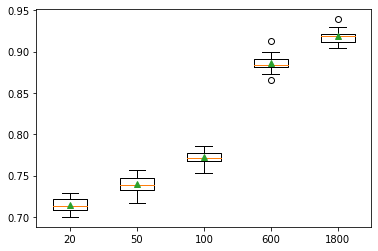

In [ ]:
# plot model performance for comparison
plt.boxplot([n_scores20,n_scores50,n_scores100,n_scores600,n_scores1800],labels=['20','50','100','600','1800'], showmeans=True)
plt.show()

It can be seen that n_estimator greatly affects the accuracy produced by XGBoost. Hyperparameter trials up to estimator 500 give the best results for estimator 500. Other trials by testing n_estimator 600 and 1800 give better results.

## Stacking

Stacking is an ensemble learning method that combines several classifier models as base learners. The prediction results from each of these models are used as input for a meta-learner classifier model to produce the final prediction result.

The base models used in this stacking include logistic regression, K-Nearest Neighbor, decision tree CART, support vector machine, and Gaussian Naive Bayes.

Next, the meta-learner is a single XGBoost classifier model with n_estimator set to 20 and a learning rate of 0.02. The model is evaluated using 10-fold cross-validation

>lr 0.822 (0.007)


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>knn 0.922 (0.007)
>cart 0.764 (0.012)
>svm 0.924 (0.006)
>bayes 0.547 (0.011)


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>stacking 0.934 (0.008)


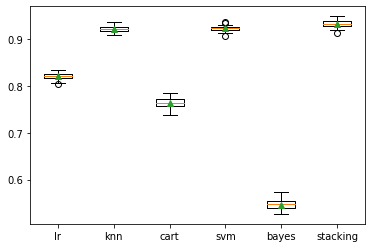

In [ ]:
# get a stacking ensemble of models
from sklearn.ensemble import StackingClassifier
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('cart', DecisionTreeClassifier()))
    level0.append(('svm', SVC()))
    level0.append(('bayes', GaussianNB()))
    # define meta learner model
    level1 = XGBClassifier(learning_rate=0.02, n_estimators=20,num_class=11, objective='multi:softmax',
                    silent=True, nthread=1)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['cart'] = DecisionTreeClassifier()
    models['svm'] = SVC()
    models['bayes'] = GaussianNB()
    models['stacking'] = get_stacking()
    return models

#evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

As seen in the figure, logistic regression has a score of 0.822, K-Nearest Neighbor has a score of 0.922, decision tree CART has a score of 0.764, support vector machine has a score of 0.924, and Gaussian Naive Bayes has a score of 0.934. The stacking method that combines these base models with an XGBoost meta-learner has a score of 0.934

In [ ]:
import pandas as pd
dataev = {'':['Mean Acc'],
          'XGB learning_rate=0.02, n_estimators=20':[0.715],
          'XGB learning_rate=0.02, n_estimators=50':[0.739],
          'XGB learning_rate=0.02, n_estimators=100':[0.772],
         'XGB learning_rate=0.02, n_estimators=600':[0.886],
        'XGB learning_rate=0.02, n_estimators=1800':[0.919],
         'logistic regression':[0.822],
         'knn':[0.922],
         'cart':[0.764],
         'svm':[0.924],
         'bayes':[0.547],
        'stacking':[ 0.934],}
pd.DataFrame(dataev).transpose()

,0
,Mean Acc
"XGB learning_rate=0.02, n_estimators=20",0.715
"XGB learning_rate=0.02, n_estimators=50",0.739
"XGB learning_rate=0.02, n_estimators=100",0.772
"XGB learning_rate=0.02, n_estimators=600",0.886
"XGB learning_rate=0.02, n_estimators=1800",0.919
logistic regression,0.822
knn,0.922
cart,0.764
svm,0.924


The conclusion from the model experiments using XGBoost and stacking is that the stacking model has the best average accuracy, with an average accuracy of 93.4% compared to XGBoost with an estimator of 1800 at 91.9%.

Using a number of estimators above 1500 will lead to better performance. The experiment did not use estimators above 1800, but based on the conclusions, estimators below 1000 do not produce good results. There is a possibility that using estimators above 1800 will achieve better results with a learning rate of 0.02.

The experiment did not use higher estimator values due to limitations in the scope of Google Colab and the runtime of the Python code. When running hyperparameter tuning, the latest results were not saved because an error occurred in Google Colab and the code stopped by itself. Earlier results were obtained with estimator 500 and a learning rate of 0.02. The BigMart dataset experiment produced a learning rate of 0.02 from hyperparameter tuning and it was used for the CODON dataset.